## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)
$$

In this project, you will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, you would be able to re-utilize parts of your previous code in this project).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
#short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

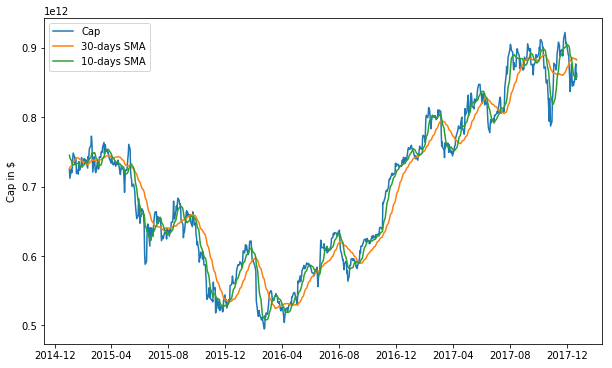

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


In [7]:
# Put the rest of you code and analysis for Part I here

#function to standardize data 
def standardize_data(df_cap, signals):
    stocks_avg_cap = df_cap.mean(axis=0)/1e9
    
    df_cap_scaled = df_cap/stocks_avg_cap
    signals = [(s/stocks_avg_cap) for s in signals]
    signals = [s/s.loc[s.first_valid_index()] for s in signals]
    
    df_cap  = (df_cap/df_cap.shift(1)).dropna().apply(np.log).dropna()
    signals = [(s/s.shift(1)).dropna().apply(np.log).dropna() for s in signals]
    
    commons_times = set(df_cap.index).intersection(*[set(s.index) for s in signals])
    
    df_cap = df_cap.loc[df_cap.index.isin(commons_times)]
    signals = [s.loc[s.index.isin(commons_times)] for s in signals]

    return df_cap, signals

s_df_cap, signals = standardize_data(df_cap, [short_rolling, long_rolling])

In [20]:
# Create Tensorflow Model Class

class IRLModel():
    def __init__(self,market_caps, signals, use_signals = True, lr = 0.0001, max_iter = 1000, tol = 1e-10, lambda_r1 = 0.01, lambda_r2 = 0.00, lambda_r3 = 0.01):
        self.min_date = market_caps.index.min()
        self.max_date = market_caps.index.max()

        self.market_caps = market_caps.sort_index()[self.min_date:self.max_date]
        self.signals  = [s.sort_index()[self.min_date:self.max_date] for s in signals]
        
        self.num_signals = len(signals)
        self.timesteps = self.market_caps.shape[0]
        self.num_stocks = self.market_caps.shape[1]
        self.use_signals = use_signals
        
        self.lr = lr
        self.max_iter = max_iter
        self.loss_tol = tol
        self.lambda_r1 = lambda_r1
        self.lambda_r2 = lambda_r2
        self.lambda_r3 = lambda_r3
        self.r_to_bps = (1-0.4)*1e4
        
        self.output  = pd.DataFrame([],index=market_caps.columns,columns=['KAPPA','SIGMA',"THETA",'G',"K","R","Y1","Y2"]+["W{}".format(i) for i in range(len(self.signals))])
    
    # prepare data function
    def prepare_data(self):
        tf.reset_default_graph()
        
        # Inputs
        self.market_cap_input = tf.placeholder(shape=(None,self.num_stocks),dtype=tf.float32,name="mcap")  # market caps input is T x N tensor
        self.signals_input = [tf.placeholder(shape=(None,self.num_stocks),dtype=tf.float32,name="s{}".format(i)) for i in range(len(self.signals))] # signals are T x N tensors
        
        # Variables to be Optimized
        if self.use_signals:
            self.weights = [tf.get_variable("w{}".format(i),initializer=tf.random_normal([self.num_stocks],mean=0.5,stddev=0.1)) for i in range(len(self.signals))]
        else:
            self.weights = [tf.constant(0.0,name="w1") for i in range(len(self.signals))]
        self.WEIGHTS = [w*tf.ones(self.num_stocks) for w in self.weights]

        # Initialization
        theta_init = np.random.normal(size=[self.num_stocks],loc=-0.5,scale=0.2).astype('float32')
        sigma_init = np.random.normal(size=[self.num_stocks],loc=0.1,scale=0.02).astype('float32')
        g_init     = np.random.normal(size=[self.num_stocks],loc=0.8,scale=0.2).astype('float32')
        kappa_init = -(2.0*np.sqrt(g_init*np.abs(theta_init-0.5*sigma_init**2))+1e-6)
        
        # Parameters
        self.theta = tf.get_variable("theta",initializer=theta_init) 
        self.sigma = tf.get_variable("sigma",initializer=sigma_init)   
        self.kappa = tf.get_variable("kappa",initializer=kappa_init)
        self.g     = tf.get_variable("g",initializer=g_init)            
        self.mu    = tf.zeros([self.num_stocks])
        self.Sigma = self.sigma*tf.ones([self.num_stocks])
        self.Kappa = self.kappa*tf.ones([self.num_stocks])
        self.G     = self.g*tf.ones([self.num_stocks])
        self.Theta = self.theta*tf.ones([self.num_stocks])
        self.Theta_bar = tf.subtract(self.Theta,tf.divide(tf.square(self.Sigma),2.0))
        self.scaled_market_cap_input  = tf.slice(self.market_cap_input,[0,0],[1,-1]) if self.use_signals else self.WEIGHTS[0]

        # Making Graph
        self.thetas = [tf.multiply(w,s) for w,s in zip(self.WEIGHTS, self.signals_input)]
        self.com_theta  = tf.multiply(self.scaled_market_cap_input ,tf.cumprod(1+tf.add_n(self.thetas)))
        self.value1 = tf.add(self.Theta_bar,self.com_theta)
        self.value2 = tf.multiply(self.Kappa,self.market_cap_input)
        self.value3 = tf.multiply(self.G,tf.square(self.market_cap_input))
        self.returns  = self.market_cap_input
        self.value = tf.add(tf.add(tf.subtract(self.returns, self.value1),self.value2),self.value3)
        self.value_scaled = tf.slice(self.value,[0,0],[tf.shape(self.value)[0]-1,-1])
        self.VALUE = tf.subtract(tf.add(self.value2,tf.multiply(0.5,self.value3)),tf.multiply(self.value1,tf.log(self.scaled_market_cap_input)))
        self.valueGradient2 =  tf.add(self.value2,tf.multiply(2.0,self.value3))

        # weights clipping
        self.neg_theta = self.theta.assign(tf.minimum(-0.001,self.Theta))
        self.neg_kappa = self.kappa.assign(tf.minimum(-0.001,self.Kappa))
        self.pos_g     = self.g.assign(tf.maximum(0.001,self.G))
        self.pos_sigma = self.sigma.assign(tf.maximum(0.001,self.Sigma))
        self.neg_paras = tf.group(self.pos_g, self.pos_sigma, self.neg_kappa, self.neg_theta)
        if self.use_signals:
            self.clip_weights = [w.assign(tf.maximum(0., w)) for w in self.weights]
            self.clip = tf.group(*self.clip_weights)
        self.under_root = tf.abs(tf.slice(tf.add(tf.square(self.Kappa),tf.multiply(tf.multiply(4.0,self.G),self.value1)),[0,0],[1,-1]))
        self.root = tf.sqrt(tf.maximum(0.,self.under_root))
        self.y_a = tf.log(-tf.divide(tf.add(self.Kappa,-self.root),tf.multiply(2.0,self.G)))
        self.y_bt = -tf.divide(tf.add(self.Kappa, self.root),tf.multiply(2.0,self.G))
        self.y_b = tf.log(tf.clip_by_value(self.y_bt, 0.01,self.y_bt))  
        self.Va = tf.subtract(tf.add(tf.multiply(self.Kappa,tf.exp(self.y_a)),tf.multiply(0.5,tf.multiply(self.G,tf.exp(tf.multiply(2.0,self.y_a))))),tf.multiply(self.value1,self.y_a))
        self.Vb = tf.subtract(tf.add(tf.multiply(self.Kappa,tf.exp(self.y_b)),tf.multiply(0.5,tf.multiply(self.G,tf.exp(tf.multiply(2.0,self.y_b))))),tf.multiply(self.value1,self.y_b))

        # Calculating second derivatives
        self.VaGradient2 = tf.add(tf.multiply(self.Kappa,tf.exp(self.y_a)),tf.multiply(2.0,tf.multiply(self.G,tf.square(tf.exp(self.y_a)))))
        self.VbGradient2 = tf.add(tf.multiply(self.Kappa,tf.exp(self.y_b)),tf.multiply(2.0,tf.multiply(self.G,tf.square(tf.exp(self.y_b)))))

        # Kramers formula for escape/default rates
        self.r_term1 = tf.divide(tf.sqrt(tf.multiply(tf.abs(self.VaGradient2),tf.abs(self.VbGradient2))),tf.multiply(2.0,math.pi))
        self.r_term2 = tf.exp(-tf.divide(tf.multiply(2.0,tf.subtract(self.Vb,self.Va)),tf.square(self.Sigma)))
        self.r_ann = tf.slice(tf.multiply(252.,tf.multiply(self.r_term1,self.r_term2)),[0,0],[1,-1])
        self.K = tf.multiply(self.r_to_bps,self.r_ann)
        
        # Regularization
        self.min_y = tf.constant(self.market_caps.min().values,name="min_y",dtype=tf.float32)
        self.reg_term_1 = tf.multiply(self.lambda_r1,tf.reduce_sum(tf.maximum(tf.subtract(self.y_b,self.min_y) ,0.)))
        self.reg_term_2 = tf.multiply(self.lambda_r2,tf.reduce_sum(tf.square(tf.add_n(self.weights)-1)))
        self.reg_term_3 = tf.multiply(self.lambda_r3,tf.reduce_sum(tf.square(tf.subtract(100.,self.K)))) 

        # Minimizing Negative Log Likelihood
        self.distribution = tf.contrib.distributions.MultivariateNormalDiag(loc=self.mu, scale_diag=self.Sigma)
        self.log_prob = self.distribution.log_prob(self.value_scaled)
        self.negative_log_likelihood = -tf.reduce_sum(self.log_prob)+self.reg_term_1+self.reg_term_2+self.reg_term_3

        # Optimizing
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        self.train_optimizer = self.optimizer.minimize(self.negative_log_likelihood)

    # Run TF Session function
    def run(self):
        self.prepare_data()
        with tf.Session() as sess:
            feed_dic = {self.market_cap_input: self.market_caps}
            feed_dic.update({op:val for op,val in zip(self.signals_input, self.signals)})
            
            sess.run(tf.global_variables_initializer())
            losses = sess.run([self.negative_log_likelihood], feed_dict=feed_dic)
            i=1
            # Print Calibration
            print( "Calibration" )
            print("Iteration|      Loss      |   difference")
            while True:
                sess.run(self.train_optimizer, feed_dict=feed_dic)
                if self.use_signals:
                    sess.run(self.clip)
                # Loss Analytics
                loss = sess.run(self.negative_log_likelihood, feed_dict=feed_dic)
                losses.append(loss)
                change_in_loss = np.abs(losses[-1]-losses[-2])
                if i%100==0:
                    print ("{:8} | {:14.4f} | {:12.4f}".format(i,loss,change_in_loss))
                if change_in_loss < self.loss_tol:
                    print('Loss converge in {} iterations!'.format(i))
                    print("Loss {}".format(loss))
                    break
                if i >= self.max_iter:
                    print('Maximum number of iterations reached (no convergence).')
                    break
                i += 1

            # Put data in pandas Dataframe.
            self.output['KAPPA'] = sess.run(self.kappa).flatten()
            self.output['SIGMA'] = sess.run(self.sigma)
            self.output['THETA'] = sess.run(self.theta)
            self.output['G'] = sess.run(self.g)
            self.output['K'] = sess.run(self.K, feed_dict=feed_dic)[0]
            self.output['R'] = sess.run(self.r_ann, feed_dict=feed_dic)[0]
            self.output['Y1'] = sess.run(self.y_a, feed_dict=feed_dic)[0]
            self.output['Y2'] = sess.run(self.y_b, feed_dict=feed_dic)[0]
            for i,weight in enumerate(self.WEIGHTS):
                self.output['W{}'.format(i)] = sess.run(weight)
    
            fitted_means = sess.run(self.com_theta, feed_dict=feed_dic)
            means_df = pd.DataFrame(fitted_means,index=self.market_caps.index,columns=self.market_caps.columns)

            potentials = sess.run(self.VALUE, feed_dict=feed_dic)
            potentials_df = pd.DataFrame(potentials,index=self.market_caps.index,columns=self.market_caps.columns)
        
            return self.output,means_df, potentials_df

In [21]:
#Run TF Model without Signals

model = IRLModel(s_df_cap, signals, use_signals=False, lr=0.0001, max_iter = 5000, tol=1e-10, lambda_r1=5e5, lambda_r2=0.00, lambda_r3=0.0)
result, mean_levels, potentials = model.run()
print(result)

Calibration
Iteration|      Loss      |   difference
     100 |    737435.6250 |    1622.0000
     200 |    599127.8750 |    1190.2500
     300 |    498197.5312 |     825.5312
     400 |    423631.2812 |     677.9062
     500 |    371677.8750 |     387.9375
     600 |    336502.0625 |     319.8750
     700 |    307126.4688 |     271.2188
     800 |    281871.1562 |     230.9375
     900 |    259865.5469 |     208.2031
    1000 |    240270.1250 |     186.9219
    1100 |    221951.4375 |     187.4219
    1200 |    201798.0938 |     145.9219
    1300 |    187830.7188 |     133.7812
    1400 |    175158.6250 |     122.0312
    1500 |    163380.7500 |     114.2500
    1600 |    152321.4062 |     107.7344
    1700 |    141735.2031 |     223.2500
    1800 |    131707.0938 |      85.8281
    1900 |    123526.3203 |      80.6484
    2000 |    115815.8984 |      75.3750
    2100 |    108646.2344 |      77.7500
    2200 |    101822.4844 |      66.8828
    2300 |     95268.8672 |      64.6328
    

In [22]:
#Run TF Model with Signals

model = IRLModel(s_df_cap, signals, use_signals=True, lr=0.0001, max_iter = 5000, tol=1e-10, lambda_r1=5e5, lambda_r2=0.00, lambda_r3=0.0)
result, mean_levels, potentials = model.run()
print(result)

Calibration
Iteration|      Loss      |   difference
     100 |    804585.6875 |    1982.6875
     200 |    642899.0000 |    1123.9375
     300 |    546846.6875 |     822.2500
     400 |    475071.9688 |     629.8750
     500 |    419003.1875 |     500.9062
     600 |    373654.0625 |     412.0625
     700 |    335747.5625 |     351.4062
     800 |    302444.2812 |     286.7812
     900 |    275788.1875 |     245.4062
    1000 |    252803.5625 |     214.7812
    1100 |    232671.3281 |     189.1094
    1200 |    214864.5156 |     167.9688
    1300 |    198984.1875 |     150.3750
    1400 |    184704.8281 |     135.6562
    1500 |    171782.0156 |     123.2812
    1600 |    160005.4375 |     112.5938
    1700 |    149215.3906 |     103.4219
    1800 |    139269.7031 |      95.7031
    1900 |    130079.9609 |      88.3750
    2000 |    121557.3281 |      82.1641
    2100 |    113597.9062 |      77.2500
    2200 |    106092.3828 |      73.0312
    2300 |     98984.9531 |      69.4297
    

Part 1 Conclusion, the calibration of the model was improved and ran more efficently than the model from the previous course.
The model was first run without signals and it did not converge with 5,000 iterations and the given tolerance of 1e-10 for a change in loss, at 4,200 iterations the loss started trending up and became volatile as it was mentioned in the class.
The model was run again, now with signals and again it did not converge with 5,000 iterations, and at this time the loss started trending up at 3,800 iterations.

## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?


In [31]:
# Put the rest of your code and analysis for Part 2 here.

#Run TF Model (Kramers formula) with Signals
with_signal = IRLModel(s_df_cap, signals, use_signals=True, lr=0.0001, max_iter=5000, tol=1e-10, lambda_r1=5e5, lambda_r2=0.00, lambda_r3=0.0)
hs_result, hs_mean_levels, hs_potentials = with_signal.run()

#Run TF Model (Kramers formula) with no Signals
no_signal = IRLModel(s_df_cap, signals,use_signals =False, lr = 0.0001, max_iter=5000, tol=1e-10, lambda_r1=5e5, lambda_r2=0.00, lambda_r3=0.0)
ns_result, ns_mean_levels, ns_potentials = no_signal.run()

weights = s_df_cap.iloc[0]*np.cumprod(1. + hs_result["W0"] * signals[0] + hs_result["W1"]*signals[1])
with_signal_prediction = (ns_result["THETA"] - 0.5*ns_result["SIGMA"]**2 + weights) - ns_result["KAPPA"]*s_df_cap - ns_result["G"]*s_df_cap**2

no_signal_prediction = (ns_result["THETA"] - 0.5*ns_result["SIGMA"]**2) - ns_result["KAPPA"]*s_df_cap - ns_result["G"]*s_df_cap**2

print(hs_result, ns_result)

Calibration
Iteration|      Loss      |   difference
     100 |    809464.4375 |    2114.6250
     200 |    636701.9375 |    1428.7500
     300 |    513850.2188 |    1064.6875
     400 |    425888.4688 |     627.6562
     500 |    370149.9375 |     501.2812
     600 |    324494.7812 |     396.9062
     700 |    289123.4688 |     323.3125
     800 |    259401.0469 |     273.8750
     900 |    234005.5625 |     235.0156
    1000 |    211945.7500 |     207.9375
    1100 |    192288.3125 |     187.0781
    1200 |    174284.0469 |     175.8125
    1300 |    154788.3594 |     327.0781
    1400 |    136971.1562 |     160.0000
    1500 |    116787.7266 |     103.4453
    1600 |    102507.6328 |     201.5000
    1700 |     90172.9844 |     100.4922
    1800 |     80562.1641 |      92.1953
    1900 |     71706.5156 |      85.2891
    2000 |     63452.4844 |      79.7266
    2100 |     55677.9883 |      73.6562
    2200 |     48436.4727 |      69.5000
    2300 |     41662.7227 |      66.0781
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in absolute


    3900 |            nan |          nan
    4000 |            nan |          nan
    4100 |            nan |          nan
    4200 |            nan |          nan
    4300 |            nan |          nan
    4400 |            nan |          nan
    4500 |            nan |          nan
    4600 |            nan |          nan
    4700 |            nan |          nan
    4800 |            nan |          nan
    4900 |            nan |          nan
    5000 |            nan |          nan
Maximum number of iterations reached (no convergence).
Calibration
Iteration|      Loss      |   difference
     100 |   1018309.6250 |    2027.7500
     200 |    847887.1875 |    1450.1875
     300 |    720174.7500 |    1135.8125
     400 |    617170.8750 |     941.0625
     500 |    537626.5000 |     719.2500
     600 |    470862.5625 |     564.9375
     700 |    417218.4062 |     494.2188
     800 |    370833.8438 |     441.0625
     900 |    328904.4688 |     401.1562
    1000 |    295253.1562 |    

Part 2 Conclusion, the model with the applied Kramers formula was first run without signals and it did not converge with 5,000 iterations and the given tolerance of 1e-10 for a change in loss, the loss started trending up at 3,200 iterations.
The model with the applied Kramers formula was run again, now with signals and again it did not converge with 5,000 iterations, and at this time the loss started trending up at 3,500 iterations.
The r values varied from 0 to 7, half the values than in part one. The applied Kramers formula helped the model to run faster and can be used as for regularization. 

## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


In [30]:
# Put the rest of your code and analysis for Part 3 here.

# The proposed signals are the Exponential moving averages (EMA)
EMA_10d = df_cap.ewm(span=10,adjust=False).mean()
EMA_30d = df_cap.ewm(span=30,adjust=False).mean()

# Standardize data
s_df_cap, signals = standardize_data(df_cap, [EMA_10d, EMA_30d])

# Run TF Model with Signals
model = IRLModel(s_df_cap, signals, use_signals=True, lr=0.0001, max_iter=5000, tol=1e-10, lambda_r1=5e5, lambda_r2=0.00, lambda_r3=0.0)
result, mean_levels, potentials = model.run()
print(result)

Calibration
Iteration|      Loss      |   difference
     100 |    886034.1250 |    2398.1250
     200 |    688418.0625 |    1444.6875
     300 |    582931.9375 |     873.3750
     400 |    506547.0000 |     673.1250
     500 |    446338.4375 |     542.2812
     600 |    396917.3125 |     454.0625
     700 |    354012.2188 |     379.3750
     800 |    317936.2500 |     364.7188
     900 |    282732.2500 |     268.4688
    1000 |    258090.1406 |     227.9531
    1100 |    236562.7188 |     202.5938
    1200 |    217465.0000 |     180.1094
    1300 |    200474.1406 |     160.7969
    1400 |    185128.2969 |     145.6875
    1500 |    171228.3438 |     132.9531
    1600 |    158568.4062 |     122.0938
    1700 |    146836.9062 |     113.0000
    1800 |    135957.3750 |     104.7969
    1900 |    125777.5469 |      95.7500
    2000 |    116212.8516 |      91.9062
    2100 |    107123.0703 |      88.3203
    2200 |     98466.2266 |      85.5469
    2300 |     90294.1484 |      78.0703
    

Part 3 Conclusion, the calibration of the model for the proposed EMA signals did not converge with 5,000 iterations and the given tolerance of 1e-10 for a change in loss, and at this time the loss started trending up at 4,100 iterations.
The model is the same as the one for the simple moving average (SMA) signal but the EMA puts more weight on the most recent data points.

## Part 4 (Optional): Show me something else (Max 10 points).

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [12]:
# Put the rest of your code and analysis for Part 4 here.